In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the selected device
print("Selected device:", device)

Selected device: cuda


In [3]:
# Define a transform to normalize the data
transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
     ]
    )


In [4]:
# Download the training set
datasset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Download the test set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 131438931.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43495760.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40214282.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15350949.85it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
datasset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [6]:
datasset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [7]:
train_loader = DataLoader(dataset=datasset,batch_size=32,shuffle=True)

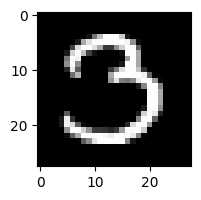

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
plt.imshow(next(iter(train_loader))[0][0].permute((1,2,0)),cmap='gray')

In [16]:
from torch import nn
class Discriminator(nn.Module):
  def __init__(self,in_features):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.LeakyReLU(0.01),
        nn.Linear(128,1),
        nn.Sigmoid()

    )

  def forward(self,x):
    return self.disc(x)

class Generator(nn.Module):
  def __init__(self,z_dim,img_dim):
    super().__init__()
    self.gen = nn.Sequential(

        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.02),
        nn.Linear(256,img_dim),
        nn.Tanh()

    )
  def forward(self,x):
    return self.gen(x)

In [28]:
z_dim = 64
image_dim = 28*28
disc = Discriminator(image_dim).to(device)
generator = Generator(z_dim,image_dim).to(device)
epochs = 10
batch_size = 32
fixed_noise = torch.rand(batch_size,z_dim).to(device)

In [29]:
optim_disc = torch.optim.Adam(disc.parameters(),lr=0.003)
optim_grn = torch.optim.Adam(generator.parameters(),lr=0.003)
# Both generator and discriminator use BCE loss
criterion = nn.BCELoss()

In [20]:
write_fake = SummaryWriter(f"log/fake")
write_real = SummaryWriter(f"log/real")
step = 0

Epoch : 0.0 Batch 0/1875 | loss D : 0.6723, Loss G : 0.7931


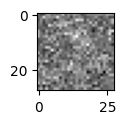

Epoch : 0.1 Batch 0/1875 | loss D : 0.0000, Loss G : 12.2332


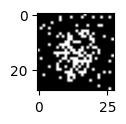

Epoch : 0.2 Batch 0/1875 | loss D : 0.0000, Loss G : 13.6562


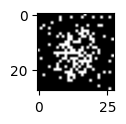

Epoch : 0.3 Batch 0/1875 | loss D : 0.0000, Loss G : 14.8485


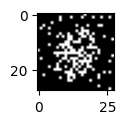

Epoch : 0.4 Batch 0/1875 | loss D : 0.0000, Loss G : 13.3110


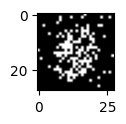

Epoch : 0.5 Batch 0/1875 | loss D : 0.0000, Loss G : 16.1141


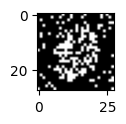

Epoch : 0.6 Batch 0/1875 | loss D : 0.0000, Loss G : 17.9116


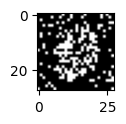

Epoch : 0.7 Batch 0/1875 | loss D : 0.0000, Loss G : 19.1923


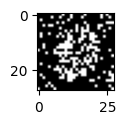

Epoch : 0.8 Batch 0/1875 | loss D : 0.0000, Loss G : 74.4624


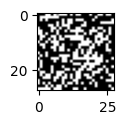

Epoch : 0.9 Batch 0/1875 | loss D : 0.0000, Loss G : 74.4727


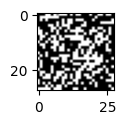

In [ ]:
from tokenize import generate_tokens
for epoch in range(epochs):
  for b,(real,_) in enumerate(train_loader):
    real = real.to(device)
    real = real.view(-1,784)


    #training discriminator
    noise = torch.rand(batch_size,z_dim).to(device)
    fake_image = generator(noise)
    # print(fake_image.shape)
    # print(real.shape)

    disc_real = disc(real)

    disc_real = disc_real.view(-1)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake_image).view(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    lossD = (lossD_real + lossD_fake)/2
    optim_disc.zero_grad()

    lossD.backward(retain_graph=True)
    optim_disc.step()


    # Training The Generator

    output = disc(fake_image).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    optim_grn.zero_grad()
    lossG.backward()
    optim_grn.step()

    if b == 0 :
      print(f"Epoch : {epoch/epochs} Batch {b}/{len(train_loader)} | loss D : {lossD:.4f}, Loss G : {lossG:.4f}")
      with torch.no_grad():
        fake = generator(fixed_noise).reshape(-1,1,28,28)
        data = real.reshape(-1,1,28,28)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        img_grid_real = torchvision.utils.make_grid(real, normalize=True)

        write_fake.add_image(
            'MNIST FAKE IMAGE',img_grid_fake,global_step = step
        )
        write_real.add_image(
            'MNIST REAL IMAGE',img_grid_real,global_step = step
        )
        step+=1
        plt.figure(figsize=(1,1))
        plt.imshow(fake[0].cpu().permute((1,2,0)),cmap='gray')
        plt.show()
